# Identifying Potential Customers Based on Reddit Posts 

#### By: Julia Kelman: [GitHub](https://git.generalassemb.ly/julia-kelman/)

## Problem Statement

We are a company who created a new product meant to help individuals with Autism Spectrum Disorder (ASD). We want to market online and as a result need to be able to identify users who are part of our target population based on their online content (reddit/facebook/blog posts for example).  
The autism community has a great online presence with many facebook groups and blogs dedicated to supporting individuals with this disorder. However, many of those groups are not restricted to people with ASD. Indeed, other disorders such as Obsessive Compulsive Disorder (OCD) share many symptoms with autism [source](https://www.webmd.com/brain/autism/autism-similar-conditions). As a result, online resources are often geared towards both of those populations.  
To start, our company will focus on identifying potential customers on one major blog for a support group for individuals with ASD and individuals with OCD.   
Since our product is specific to individuals with ASD, we need to be able to differentiate between people with ASD and OCD based on what they post on this online platform.  
We plan to solve this problem by using submissions on an Autism reddit page and an OCD reddit page to build a classification model able to classify a user as having either ASD or OCD based on their post with the highest level of accuracy possible.   
This model could then be used to identify potential customers on blogs for people with autism or OCD. 

## Executive Summary

TBD

## Table of Contents 

- [Reddit Data Import](#Loading-Data) 
- [Data Cleaning](#Data-Cleaning) 
- [Exploratory Data Analysis](#EDA) 
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)  
    - [Baseline Model](#Baseline-Model)  
    - [Logistic Regression](#Logistic-Regression)
        - [Logistic Regression + CountVectorizer](#Logistic-Regression-+-CountVectorizer)
        - [Logistic Regression + TFIDFVectorizer](#Logistic-Regression-+-TFIDFVectorizer)
    - [kNN](#kNN)  
        - [kNN + CountVectorizer](#kNN-+-CountVectorizer)
        - [kNN + TFIDFVectorizer](#kNN-+-TFIDFVectorizer)
    - [Naive Bayes](#Naive-Bayes) 
        - [Multinomial Naive Bayes + CountVectorizer](#Multinomial-Naive-Bayes-+-CountVectorizer)  
        - [Gaussian NB + TFIDFVectorizer](#Gaussian-NB-+-TFIDFVectorizer)
    - [SVC](#SVC)
        - [SVC + CountVectorizer](#SVC-+-CountVectorizer)
        - [SVC + TFIDFVectorizer](#SVC-+-TFIDFVectorizer)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion & Recommendations](#Conclusion-and-Recommendations)
- [References](#References)

## Loading Data

In [1]:
# Library imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import regex as re
import string
from bs4 import BeautifulSoup             
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline 

In [2]:
# Loading data 
data = pd.read_csv("./data/data.csv")

In [3]:
data.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Was convinced to try an outpatient treatment p...,[removed],OCD,1584570256,stringthanks,0,1,True,2020-03-18
1,To anyone who has contamination ocd: what are ...,NaN,OCD,1584570641,Mental_senstrias,9,1,True,2020-03-18
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",OCD,1584570720,BigOof673,2,2,True,2020-03-18
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",OCD,1584570825,Bobby_Crazykite,4,3,True,2020-03-18
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,OCD,1584570850,JakeHassle,0,1,True,2020-03-18


In [4]:
data.shape

(3862, 9)

## Data Cleaning

In [5]:
# Since the timeframe column is derived from the created_utc column and gives us more useful
# information, we can delete the created_utc variable 
data.drop(columns=['created_utc'], inplace=True)

In [6]:
# Since our goal is to identify users with ASD, let's reformat the subreddit feature 
# with autism = 1 and OCD = 0 
data['subreddit'] = data['subreddit'].map({'autism':1, "OCD":0})

In [7]:
data['subreddit'].value_counts()

0    2209
1    1653
Name: subreddit, dtype: int64

In [8]:
# Checking for nulls
data.isnull().sum()

title             0
selftext        177
subreddit         0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

We want to look at any type of text posted by users, whether it is title or main text. As a result, we will combine the title and selftext features into one text feature. This will also resolve the issue of selftext missing values. 
In order to do this we first need to make sure that we are not including reddit imputed text such as [removed] in there.  

In [9]:
# Looking for major reddit imputed values 
data['selftext'].value_counts().head(3)

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               311
[deleted]                                                                                                                                                                                                                                                                                                                                                                   

In [10]:
# changing [removed] and [deleted] into empty string. 
data['selftext'].replace('[removed]', "", inplace=True)
data['selftext'].replace('[deleted]', "", inplace=True)

In [11]:
# changing NaNs into empty strings 
data['selftext'].fillna("", inplace=True)

In [12]:
# Checking title feature for reddit imputed text
data['title'].value_counts().head(3)

Question                                                                           8
hi                                                                                 5
I have an obsession with dying that has last for years and is driving me insane    3
Name: title, dtype: int64

There does not seem to be any reddit imputed text in the titles.

In [13]:
# Combining title and selftext into text 
data['text'] = data['title'] + " " + data['selftext']

In [14]:
data.head()

,title,selftext,subreddit,author,num_comments,score,is_self,timestamp,text
0,Was convinced to try an outpatient treatment p...,,0,stringthanks,0,1,True,2020-03-18,Was convinced to try an outpatient treatment p...
1,To anyone who has contamination ocd: what are ...,,0,Mental_senstrias,9,1,True,2020-03-18,To anyone who has contamination ocd: what are ...
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",0,BigOof673,2,2,True,2020-03-18,Sertraline HCL (Generic Zoloft) w/out Insuranc...
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",0,Bobby_Crazykite,4,3,True,2020-03-18,Feeling like going mad I suffer from severe OC...
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,0,JakeHassle,0,1,True,2020-03-18,Worried about this sticky adhesive So I notice...


In [15]:
# Checking we no longer have any nulls 
data.isnull().sum()

title           0
selftext        0
subreddit       0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
text            0
dtype: int64

In [16]:
# Confirming that all our submissions are self posts
data['is_self'].value_counts()

True    3862
Name: is_self, dtype: int64

Since all observations have the same value of "True", this feature does not bring much information for our model. We will therefore drop it. 

In [17]:
data.drop(columns='is_self', inplace=True)

In [18]:
data.head()

,title,selftext,subreddit,author,num_comments,score,timestamp,text
0,Was convinced to try an outpatient treatment p...,,0,stringthanks,0,1,2020-03-18,Was convinced to try an outpatient treatment p...
1,To anyone who has contamination ocd: what are ...,,0,Mental_senstrias,9,1,2020-03-18,To anyone who has contamination ocd: what are ...
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",0,BigOof673,2,2,2020-03-18,Sertraline HCL (Generic Zoloft) w/out Insuranc...
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",0,Bobby_Crazykite,4,3,2020-03-18,Feeling like going mad I suffer from severe OC...
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,0,JakeHassle,0,1,2020-03-18,Worried about this sticky adhesive So I notice...


In [19]:
# Creating a function for text cleaning
def cleaning(text):
    # remove html
    text = BeautifulSoup(text).get_text()

    exclude = set(string.punctuation)
    # remove new line and digits with regular expression
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\d', '', text)
    
    # remove patterns matching url format
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    text = re.sub(url_pattern, ' ', text)
    
    # remove punctuations
    text = ''.join(character for character in text if character not in exclude)
    # standardize white space
    text = re.sub(r'\s+', ' ', text)
    # drop capitalization
    text = text.lower()
    #remove white space
    text = text.strip()
    
    #lemmatizing 
    p_stemmer = PorterStemmer()   
    tokenizer = RegexpTokenizer(r'\w+')
    text = [p_stemmer.stem(i) for i in tokenizer.tokenize(text)]
    
    return (" ".join(text))
# Function adapted from https://codereview.stackexchange.com/questions/186614/text-cleaning-script-producing-lowercase-words-with-minimal-punctuation

In [20]:
# Cleaning our text data 
cleaned_text = [cleaning(text) for text in data['text']]

In [21]:
# Adding our cleaned text as a new column to our dataframe 
data['cleaned_text'] = cleaned_text

In [22]:
# comparing original text and cleaned text to make sure it has been appropriately cleaned
data['text'][4]

'Worried about this sticky adhesive So I noticed that the little circles on cabinets that soften the impact when you close it look like this now on my cabinets:\n\n\nhttps://imgur.com/a/bpPzhWL\n\nThey look like they busted and the bottom pic shows one close to the stove so it’s greasy. I touched the first one and it felt like some really sticky adhesive that would get every where and it took forever to wash off my hands. I pointed it out to my parents and then they decided too touch it as well, but they didn’t wash it off their hands. Now for some reason I’m getting a lot of stress about how everything they’re touching will get the adhesive on it. It’s really ruining my day and I don’t know why it’s so much.'

In [23]:
cleaned_text[4]

'worri about thi sticki adhes so i notic that the littl circl on cabinet that soften the impact when you close it look like thi now on my cabinet look like they bust and the bottom pic show one close to the stove so it s greasi i touch the first one and it felt like some realli sticki adhes that would get everi where and it took forev to wash off my hand i point it out to my parent and then they decid too touch it as well but they didn t wash it off their hand now for some reason i m get a lot of stress about how everyth they re touch will get the adhes on it it s realli ruin my day and i don t know whi it s so much'

Our final cleaned text seems appropriately cleaned.

In [24]:
data.head()

,title,selftext,subreddit,author,num_comments,score,timestamp,text,cleaned_text
0,Was convinced to try an outpatient treatment p...,,0,stringthanks,0,1,2020-03-18,Was convinced to try an outpatient treatment p...,wa convinc to tri an outpati treatment program...
1,To anyone who has contamination ocd: what are ...,,0,Mental_senstrias,9,1,2020-03-18,To anyone who has contamination ocd: what are ...,to anyon who ha contamin ocd what are your pho...
2,Sertraline HCL (Generic Zoloft) w/out Insurance?,"Amid the coronavirus economic recession, there...",0,BigOof673,2,2,2020-03-18,Sertraline HCL (Generic Zoloft) w/out Insuranc...,sertralin hcl gener zoloft wout insur amid the...
3,Feeling like going mad,"I suffer from severe OCD, related to magic thi...",0,Bobby_Crazykite,4,3,2020-03-18,Feeling like going mad I suffer from severe OC...,feel like go mad i suffer from sever ocd relat...
4,Worried about this sticky adhesive,So I noticed that the little circles on cabine...,0,JakeHassle,0,1,2020-03-18,Worried about this sticky adhesive So I notice...,worri about thi sticki adhes so i notic that t...


In [25]:
data.dtypes

title           object
selftext        object
subreddit        int64
author          object
num_comments     int64
score            int64
timestamp       object
text            object
cleaned_text    object
dtype: object

## EDA

In [26]:
data.describe()

,subreddit,num_comments,score
count,3862.000000,3862.000000,3862.000000
mean,0.428017,5.658985,1.017866
std,0.494855,8.957465,0.212146
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,3.000000,1.000000
75%,1.000000,7.000000,1.000000
max,1.000000,182.000000,8.000000


In [27]:
# Looking at the average number of comments for each subreddits 
data.groupby('subreddit')['num_comments'].mean()

subreddit
0    3.973744
1    7.911071
Name: num_comments, dtype: float64

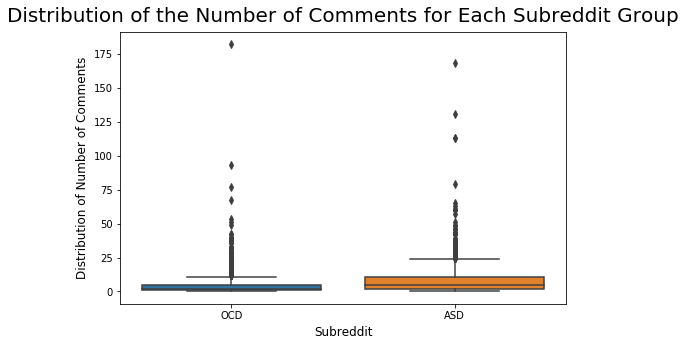

In [28]:
# Visualizing the distribution of number of comments for each subreddits 
plt.figure(figsize=(8,5)) 
plt.title("Distribution of the Number of Comments for Each Subreddit Group", fontsize = 20, pad = 10)
sns.boxplot(x = data['subreddit'], y = data['num_comments'])
plt.xlabel("Subreddit", fontsize = 12, labelpad = 5)
plt.ylabel("Distribution of Number of Comments", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['OCD', 'ASD']);

**Interpretation:** There seems to be a high number of outliers in the number of comments for both the OCD and ASD groups.   
However, there is no evidence to prove that those values are not valid data. As a result, we will no remove them.

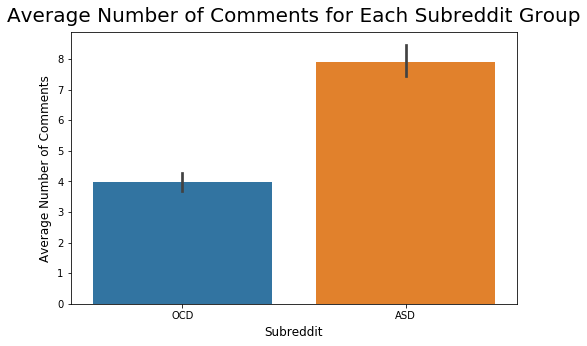

In [29]:
# Visualizing the average number of comments for each subreddits 
plt.figure(figsize=(8,5)) 
plt.title("Average Number of Comments for Each Subreddit Group", fontsize = 20, pad = 10)
sns.barplot(x=data['subreddit'], y=data['num_comments'])
plt.xlabel("Subreddit", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Comments", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['OCD', 'ASD']);

**Interpretation:** On average, there is a higher number of comments posted in response to submissions on the autism subreddit compared to the OCD subreddit. 

In [30]:
data.groupby('subreddit')['score'].mean()

subreddit
0    1.016297
1    1.019964
Name: score, dtype: float64

The two groups have very similar mean scores 

In [31]:
data.groupby('subreddit')['timestamp'].describe()

,count,unique,top,freq
subreddit,,,,
0,2209,34,2020-02-20,98
1,1653,50,2020-02-18,62


Highest number of submissions on the autism subreddit posted on Tuesday Feb. 18th 2020.  
Highest number of submissions on the OCD subreddit posted on Thursday Feb. 20th 2020. 

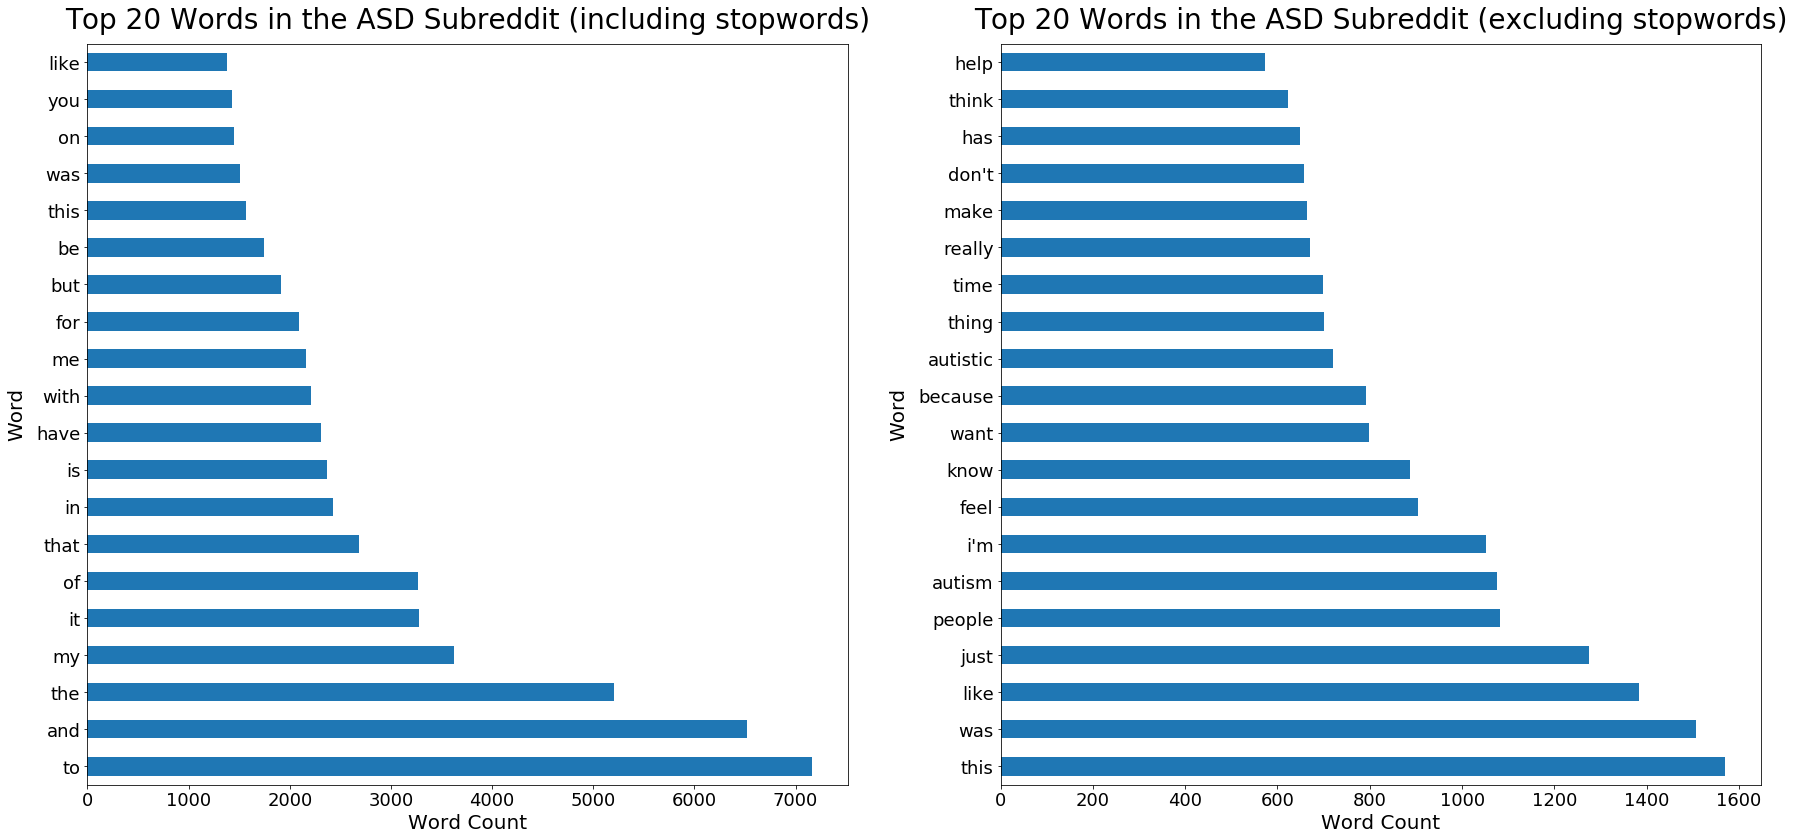

In [32]:
# Visualizing the 20 most frequent words in the ASD subreddit with and without stopwords

#Creating with matrix with the 20 most common ASD words including stopwords
cvec = CountVectorizer(max_features = 20)
test_text = cvec.fit_transform(data[data['subreddit']==1]['cleaned_text'])
test_df_asd = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Creating with matrix with the 20 most common ASD words excluding stopwords
cvec = CountVectorizer(max_features = 20, stop_words='english')
test_text = cvec.fit_transform(data[data['subreddit']==1]['cleaned_text'])
test_df_asd_no_stop = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Visualizing the 20 most common ASD words including stopwords 
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
test_df_asd.sum().sort_values(ascending=False).plot(kind='barh')
plt.title('Top 20 Words in the ASD Subreddit (including stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['to', 'and', 'the', 'my', 'it', 'of', 'that', 'in', 'is', 'have', 'with', 'me', 
           'for', 'but', 'be', 'this', 'was', 'on', 'you', 'like']);

#Visualizing the 20 most common ASD words excluding stopwords 
plt.subplot(2,2,2)
test_df_asd_no_stop.sum().sort_values(ascending=False).plot(kind='barh')
plt.title('Top 20 Words in the ASD Subreddit (excluding stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['this', 'was', 'like', 'just', 'people', 'autism', "i'm", 'feel', 'know', 'want',
           'because', 'autistic', 'thing','time', 'really', 'make', "don't", 'has', 'think', 'help']);

# Code for this visual adapted from code by Matthew Malone 

**Interpretation:** A majority of the 20 most frequent words in the ASD reddit are common stopwords. As a result, it may be a good idea to remove stopwords in our model. When we remove those, we are seeing a lot more words related to autism appear as "top words"

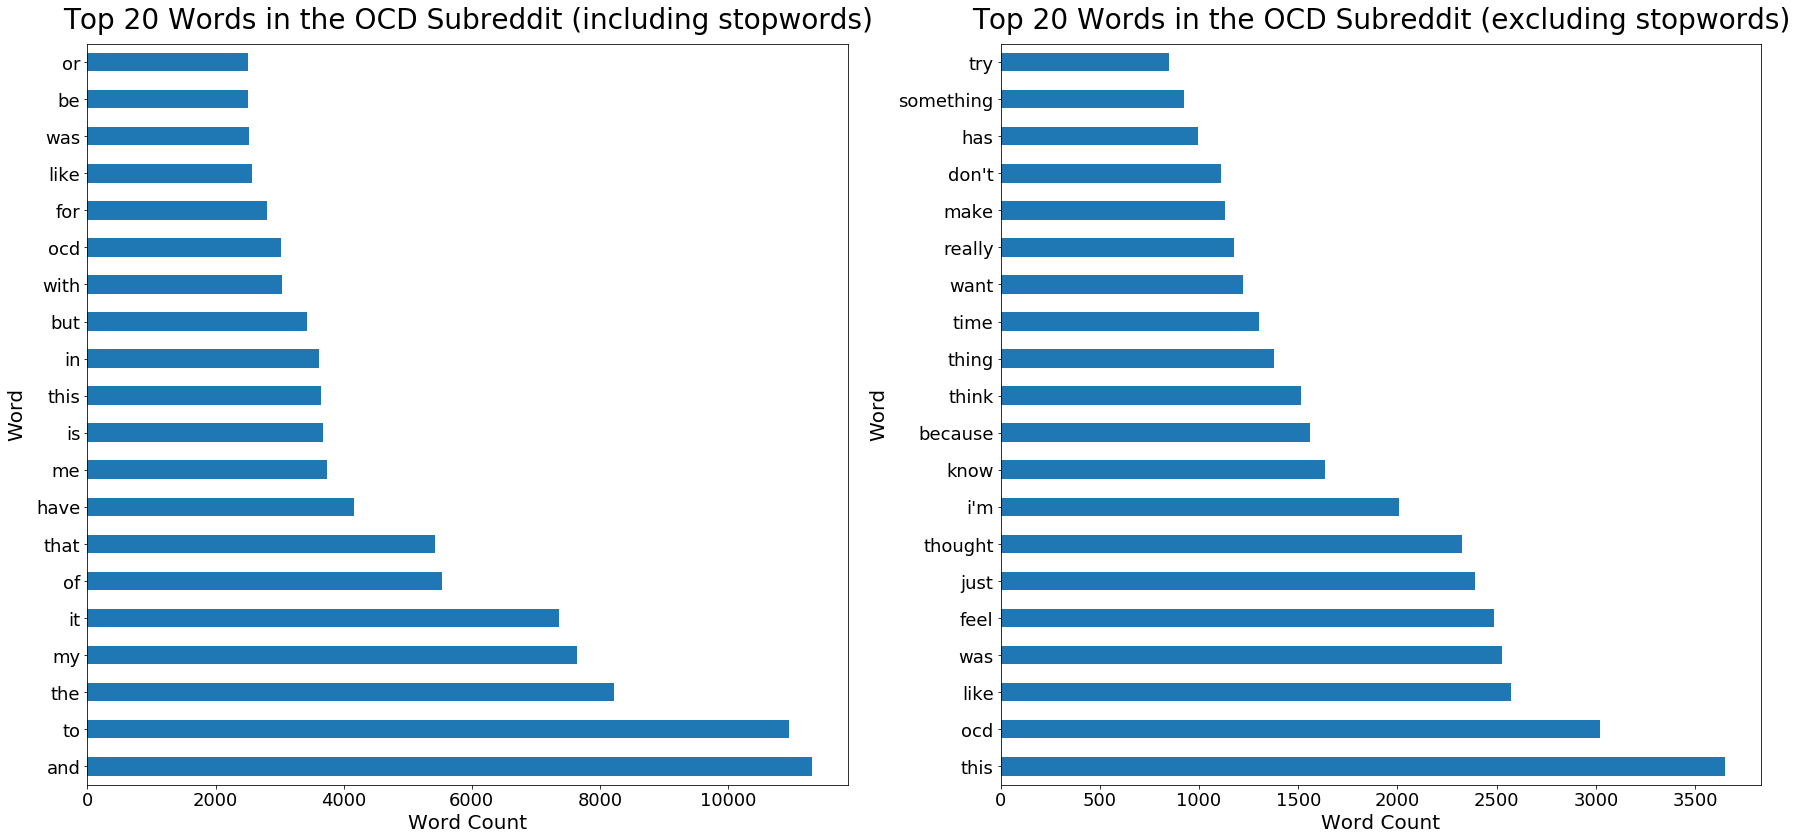

In [33]:
# Visualizing the 20 most frequent words in the OCD subreddit with and without stopwords

#Creating with matrix with the 20 most common OCD words including stopwords
cvec = CountVectorizer(max_features = 20)
test_text = cvec.fit_transform(data[data['subreddit']==0]['cleaned_text'])
test_df_ocd = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Creating with matrix with the 20 most common OCD words excluding stopwords
cvec = CountVectorizer(max_features = 20, stop_words='english')
test_text = cvec.fit_transform(data[data['subreddit']==0]['cleaned_text'])
test_df_ocd_no_stop = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

#Visualizing the 20 most common OCD words including stopwords 
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
test_df_ocd.sum().sort_values(ascending=False).plot(kind='barh');
plt.title('Top 20 Words in the OCD Subreddit (including stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['and', 'to', 'the', 'my', 'it', 'of', 'that', 'have', 'me', 'is', 'this', 'in', 
           'but', 'with', 'ocd', 'for', 'like', 'was', 'be', 'or']);


#Visualizing the 20 most common OCD words excluding stopwords 
plt.subplot(2,2,2)
test_df_ocd_no_stop.sum().sort_values(ascending=False).plot(kind='barh')
plt.title('Top 20 Words in the OCD Subreddit (excluding stopwords)', size=28, pad=15)
plt.xlabel('Word Count', size=20)
plt.tick_params(labelsize = 18)
plt.ylabel('Word', size=20, labelpad=10)
plt.yticks(np.arange(20), 
           ['this', 'ocd', 'like', 'was', 'feel', 'just', 'thought', "i'm", 'know', 'because', 
           'think', 'thing', 'time', 'want', 'really', 'make', "don't", 'has', 'something', 'try']);

# Original code for this visual brought to you by Matthew Malone 

**Interpretation:** A majority of the 20 most frequent words in the ASD reddit are common stopwords. As a result, it may be a good idea to remove stopwords in our model.

In [34]:
# Creating lists for 20 most common OCD and ASD words 
top_ocd = list(test_df_ocd_no_stop.columns)
top_asd = list(test_df_asd_no_stop.columns)

# Creating a list of words that are part on the 20 most common words in both subreddits 
all_words = set(top_ocd + top_asd)
top_ocd_and_asd = [w for w in all_words if (w in top_ocd) and (w in top_asd)]

In [35]:
# Creating a function labeling a word as either part of the top ASD words, top OCD words, or both
def subreddit(row):
    if row in top_ocd_and_asd: 
        subreddit = 'both'
    elif row in top_asd:
        subreddit = 'ASD'
    else: 
        subreddit = 'OCD'
    return subreddit 

In [36]:
cvec = CountVectorizer(max_features = 20, stop_words='english')
test_all_text = cvec.fit_transform(data['cleaned_text'])
test_all_text_df = pd.DataFrame(test_all_text.toarray(), columns=cvec.get_feature_names())

new_df = test_all_text_df.T
new_df['total'] = list(test_all_text_df.sum())

new_df_2 = new_df[['total']]
new_df_2 = new_df_2.sort_values(by='total')
new_df_2.loc[new_df_2.index, 'subreddit'] = [subreddit(word) for word in new_df_2.index]
# code adapted from https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition

In [37]:
new_df_2.head()

,total,subreddit
help,1400,ASD
ha,1641,both
dont,1767,both
make,1796,both
peopl,1819,ASD


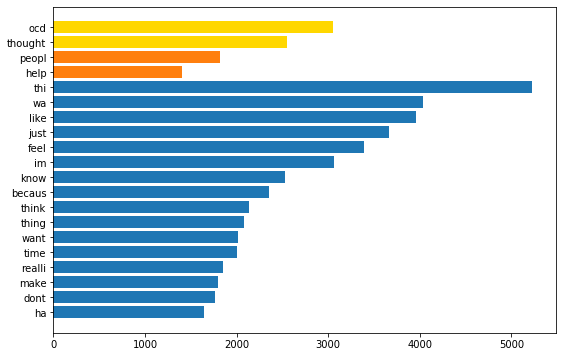

In [38]:
fig, ax = plt.subplots(figsize = (9,6))
ax.barh(width=new_df_2[new_df_2['subreddit']=='both']['total'], y=new_df_2[new_df_2['subreddit']=='both'].index)
ax.barh(width=new_df_2[new_df_2['subreddit']=='ASD']['total'], y=new_df_2[new_df_2['subreddit']=='ASD'].index)
ax.barh(width=new_df_2[new_df_2['subreddit']=='OCD']['total'], y=new_df_2[new_df_2['subreddit']=='OCD'].index, color='gold');

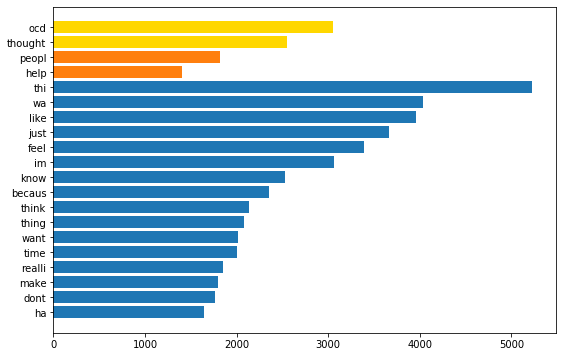

In [39]:
plt.figure(figsize = (9,6))
plt.barh(width=new_df_2[new_df_2['subreddit']=='both']['total'], y=new_df_2[new_df_2['subreddit']=='both'].index)
plt.barh(width=new_df_2[new_df_2['subreddit']=='ASD']['total'], y=new_df_2[new_df_2['subreddit']=='ASD'].index)
plt.barh(width=new_df_2[new_df_2['subreddit']=='OCD']['total'], y=new_df_2[new_df_2['subreddit']=='OCD'].index, color='gold');

Words that are in both ASD and OCD subreddit should be included in stopwords.  
While we are only showing the most frequent 20 words here, the same analysis was done with the most frequent 40 words in order to identify more potential stopwords. 

In [40]:
# more info about the context of the words 

## Model Preparation

In [57]:
# Creating matrices for the most common 40 words in the ASD and OCD subreddits 
cvec = CountVectorizer(max_features = 50, stop_words='english')

test_text = cvec.fit_transform(data[data['subreddit']==1]['cleaned_text'])
test_auti = pd.DataFrame(test_text.toarray(), columns=cvec.get_feature_names())

test_text2 = cvec.fit_transform(data[data['subreddit']==0]['cleaned_text'])
test_ocid = pd.DataFrame(test_text2.toarray(), columns=cvec.get_feature_names())

In [58]:
# Create custom list of stopwords 
additional_words = [word for word in test_auti.columns if word in test_ocid.columns]
my_stopwords = frozenset(additional_words+ stopwords.words('english'))

In [59]:
# Setting up our variables and train-test split
X = data['cleaned_text']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Modeling

### Baseline Model

In [55]:
# Checking baseline model score 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print(f'Baseline Score: {dummy.score(X_test, y_test)}')

Baseline Score: 0.572463768115942


**Interpretation:** If we always predicted the majority class, our "model" would have a 57% accuracy. 

### Logistic Regression

#### Logistic Regression + CountVectorizer 

In [45]:
#Creating pipeline for Log Reg CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()), 
    ('lg', LogisticRegression(solver='liblinear')) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2), (2,2)], 
    'vectorizer__stop_words': ['english', None, my_stopwords],
    'vectorizer__max_features': [1000, 2000],
    'lg__max_iter': [200]
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
lg_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {lg_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg_cvec.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.9920580110497238
Best Testing Accuracy: 0.9244306418219461
Cross-val-score: 0.9202498173457828


In [46]:
lg_cvec.best_params_

{'lg__max_iter': 200,
 'vectorizer__max_features': 2000,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': 'english'}

#### Logistic Regression + TFIDFVectorizer

In [68]:
#Creating pipeline for Log Reg TFIDFVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()), 
    ('lg', LogisticRegression(solver='liblinear')) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2), (2,2)], 
    'vectorizer__stop_words': ['english', my_stopwords],
    'vectorizer__max_features': [3000, 3300],
    'lg__max_iter': [50, 100, 150], 
    'lg__penalty': ['l2'],
    'lg__C': [3]
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
lg_tfidf = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {lg_tfidf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg_tfidf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg_tfidf.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.988950276243094
Best Testing Accuracy: 0.9337474120082816
Cross-val-score: 0.9259456126121899


In [69]:
lg_tfidf.best_params_

{'lg__C': 3,
 'lg__max_iter': 50,
 'lg__penalty': 'l2',
 'vectorizer__max_features': 3000,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': frozenset({'a',
            'about',
            'above',
            'after',
            'again',
            'against',
            'ain',
            'all',
            'alway',
            'am',
            'an',
            'and',
            'ani',
            'any',
            'anyon',
            'are',
            'aren',
            "aren't",
            'as',
            'at',
            'be',
            'becaus',
            'because',
            'been',
            'before',
            'being',
            'below',
            'between',
            'both',
            'but',
            'by',
            'can',
            'couldn',
            "couldn't",
            'd',
            'day',
            'did',
            'didn',
            "didn't",
            'do',
            'does',
            'doesn',
     

### kNN 

#### kNN + CountVectorizer

In [49]:
#Creating pipeline for kNN CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()),
    ('sc', MaxAbsScaler()),
    ('knn', KNeighborsClassifier())
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2), (2,2)], 
    'vectorizer__stop_words': ['english', None, my_stopwords],
    'vectorizer__max_features': [400, 500],
    'knn__n_neighbors': [10, 15], 
    'knn__metric': ['minkowski']
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
knn_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {knn_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {knn_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(knn_cvec.best_estimator_, X, y).mean()}')

Best Training Accuracy: 0.7855662983425414
Best Testing Accuracy: 0.7329192546583851
Cross-val-score: 0.7356363404808666


In [50]:
knn_cvec.best_params_

{'knn__metric': 'minkowski',
 'knn__n_neighbors': 10,
 'vectorizer__max_features': 400,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': frozenset({'a',
            'about',
            'above',
            'after',
            'again',
            'against',
            'ain',
            'all',
            'alway',
            'am',
            'an',
            'and',
            'ani',
            'any',
            'anyon',
            'anyth',
            'are',
            'aren',
            "aren't",
            'as',
            'at',
            'be',
            'becaus',
            'because',
            'been',
            'before',
            'being',
            'below',
            'between',
            'both',
            'but',
            'by',
            'can',
            'come',
            'couldn',
            "couldn't",
            'd',
            'day',
            'did',
            'didn',
            "didn't",
            'do',
        

#### kNN + TFIDFVectorizer

In [51]:
#Creating pipeline for kNN TFIDFVectorizer: 

# Setting model specific train/test split
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, random_state=22, stratify=y)

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()), 
    ('sc', MaxAbsScaler()),
    ('knn', KNeighborsClassifier()) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2), (2,2)], 
    'vectorizer__stop_words': ['english', None, my_stopwords],
    'vectorizer__max_features': [2300, 2200],
    'knn__n_neighbors': [10, 8], 
    'knn__metric': ['minkowski']
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
knn_tfidf = gs.fit(X_train_knn, y_train_knn)

# Scoring 
print(f'Best Training Accuracy: {knn_tfidf.score(X_train_knn, y_train_knn)}')
print(f'Best Testing Accuracy: {knn_tfidf.score(X_test_knn, y_test_knn)}')
print(f'Cross-val-score: {cross_val_score(knn_tfidf.best_estimator_, X, y).mean()}')

KeyboardInterrupt: 

In [ ]:
knn_tfidf.best_params_

### Naive Bayes

#### Multinomial Naive Bayes + CountVectorizer

In [ ]:
#Creating pipeline for Multinomial NB CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()), 
    ('mnb', MultinomialNB()) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2), (2,2)], 
    'vectorizer__stop_words': ['english', None, my_stopwords],
    'vectorizer__max_features':  [2500, 2200], 
    'mnb__alpha': [0.2, 0.3]
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
mnb_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {mnb_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {mnb_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(mnb_cvec.best_estimator_, X, y).mean()}')

In [ ]:
mnb_cvec.best_params_

#### Gaussian NB + TFIDFVectorizer

In [ ]:
#Creating pipeline for Gaussian NB TFIDFVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()), 
    ('denser', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('gnb', GaussianNB()) 
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2), (2,2)], 
    'vectorizer__stop_words': ['english', None, my_stopwords],
    'vectorizer__max_features': [2000, 3000],
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
gnb_tfidf = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {gnb_tfidf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {gnb_tfidf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(gnb_tfidf.best_estimator_, X, y).mean()}')

#Fix to sparse array error from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

In [ ]:
gnb_tfidf.best_params_

### SVC

#### SVC + CountVectorizer

In [ ]:
#Creating pipeline for SVC CountVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', CountVectorizer()),
    ('sc', MaxAbsScaler()),
    ('svc', SVC())
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2)], 
    'vectorizer__stop_words': ['english', None, my_stopwords],
    'vectorizer__max_features': [250, 300, 350],
    'svc__degree': [0.2, 0.5, 2], 
    'svc__C': [8, 10, 12]
   
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
svc_cvec = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {svc_cvec.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {svc_cvec.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(svc_cvec.best_estimator_, X, y).mean()}')

In [ ]:
svc_cvec.best_params_

#### SVC + TFIDFVectorizer 

In [70]:
#Creating pipeline for SVC TFIDFVectorizer: 

# Define Pipeline
pipe = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer()),
    ('sc', MaxAbsScaler()),
    ('svc', SVC())
])

# Construct Grid Parameters
hyperparams = {
    'vectorizer__ngram_range':[(1,1), (1,2)], 
    'vectorizer__stop_words': ['english', None, my_stopwords],
    'vectorizer__max_features': [300, 350, 400],
    'svc__degree': [0.2, 0.5, 2], 
    'svc__C': [8, 10, 12], 
    'svc__kernel': ['poly', 'rbf']
   
}

# Perform Grid Search
gs = GridSearchCV(pipe,
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
svc_tfidf = gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {svc_tfidf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {svc_tfidf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(svc_tfidf.best_estimator_, X, y).mean()}')

KeyboardInterrupt: 

## Model Selection

## Model Evaluation

In [ ]:
# confusion matrix 
# you can look at your misclassifications (look at specific ones and explain them)

## Conclusion and Recommendations 

## References

[Autism Reddit](https://www.reddit.com/r/autism/)  
[OCD Reddit](https://www.reddit.com/r/OCD/)  
[OCD resembles ASD](https://www.webmd.com/brain/autism/autism-similar-conditions)